# Image Classification Using CNN
### Mengklasifikasikan Gambar Kucing dan Anjing

Diajukan untuk memenuhi Final Project UAS Mata Kuliah Kecerdasan Buatan Kelas E081<br>
Anggota Kelompok:<br>
&emsp;1. Ardiana Deka Maharani     (20081010243)<br>
&emsp;2. Bregsi Atingsari Julastri (20081010211)<br>
&emsp;3. Syalum Marsya Pruista     (20081010244)<br>

In [2]:
# import library yang dibutuhkan
import tensorflow as tf  # akan digunakan saat proses deep learning
import os  # digunakan untuk menunjukkan struktur file

import cv2  # digunakan untuk mengolah gambar
import imghdr  # digunakan untuk memastikan tipe gambar

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Prepare The Datasets

In [4]:
# if dataset from google drive / running in google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
data_dir = 'dataset' # menunjukkan lokasi data yang akan dipakai

In [6]:
# digunakan untuk mengecek gambar, hanya ekstensi berikut yang diproses
image_exts = ['jpeg','jpg', 'bmp', 'png']

# menyeleksi dataset
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) # mencoba load gambar menggunakan opencv
            tip = imghdr.what(image_path)
            # proses seleksi jika format tidak sesuai, maka akan dihapus
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

## Load Data

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# memuat data menggunakan 'keras' ke dalam tahap praproses
data = tf.keras.utils.image_dataset_from_directory('dataset')

# return semua elemen dataset menjadi numpy.
data_iterator = data.as_numpy_iterator()

Found 1500 files belonging to 2 classes.


In [9]:
# cek jumlah masing2 data, tidak boleh memiliki selisih yang jauh
cats_dir = 'dataset/cats'
dogs_dir = 'dataset/dogs'

print('total cat images:', len(os.listdir(cats_dir)))
print('total dog images:', len(os.listdir(dogs_dir)))

total cat images: 750
total dog images: 750


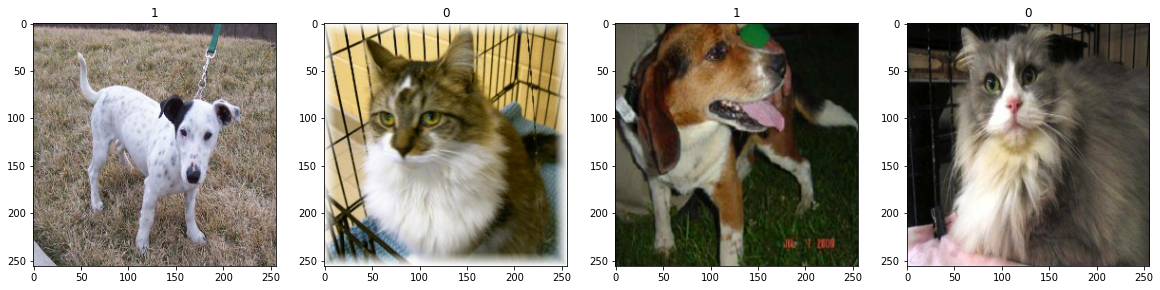

In [12]:
# mendapatkan batch lain dari sebuah iterator
batch = data_iterator.next()

# melihat contoh dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 1 = gambar anjing
# 0 = gambar kucing

## Scale Data
Ubah rentang data dari 0-255 menjadi 0-1 agar mempercepat proses

In [9]:
data = data.map(lambda x,y: (x/255, y))

In [10]:
data.as_numpy_iterator().next()

(array([[[[0.19607843, 0.19607843, 0.15686275],
          [0.19827893, 0.19827893, 0.15906323],
          [0.20150122, 0.20150122, 0.16228554],
          ...,
          [0.27391237, 0.25972733, 0.22443321],
          [0.2806679 , 0.24482231, 0.23529412],
          [0.28235295, 0.24313726, 0.23529412]],
 
         [[0.19737059, 0.19737059, 0.15815489],
          [0.2       , 0.2       , 0.16078432],
          [0.20317467, 0.20317467, 0.16395898],
          ...,
          [0.28235295, 0.26816788, 0.23287377],
          [0.2833793 , 0.2475337 , 0.23800552],
          [0.28506434, 0.24584866, 0.23800552]],
 
         [[0.2       , 0.2       , 0.16078432],
          [0.20202577, 0.20202577, 0.16281009],
          [0.20579152, 0.20579152, 0.16657583],
          ...,
          [0.28869486, 0.27450982, 0.23921569],
          [0.28876773, 0.25360358, 0.24373469],
          [0.2901961 , 0.25217524, 0.24373469]],
 
         ...,
 
         [[0.55970305, 0.51264423, 0.46558538],
          [0.53171

In [11]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

## Split Data
Membagi data menjadi data training, validation, dan testing

In [12]:
train_size = int(len(data)*.7) # training data sebesar 70%
val_size = int(len(data)*.2) # validation data 20% (untuk mengevaluasi)
test_size = int(len(data)*.1) # testing data 10%

In [13]:
print('Jumlah data latih:', train_size)
print('Jumlah data validasi:', val_size)
print('Jumlah data uji:', test_size)

Jumlah data latih: 32
Jumlah data validasi: 9
Jumlah data uji: 4


In [14]:
# take : mengambil suatu batch data
# skip : melewati batch data yang telah digunakan

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build Deep Learning Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

Sequential model digunakan karena paling mudah diterapkan, mengizinkan kita membuat model layer per layer.
#### Fungsi masing-masing layer:
Conv2D = untuk operasi konvolusional pada gambar latih<br>
MaxPooling2D = untuk operasi pooling<br>
Dense = untuk menjalankan full connection neural network<br>
Flatten = untuk convert data menjadi 1 dimensi<br>
Dropout = secara acak menetapkan unit input ke 0, mencegah overfitting<br>

In [16]:
model = Sequential()

In [17]:
# membuat layer-layer pada deep learning

# Conv2D(jumlah filter, (ukuran px), perpindahan per 1 px, )
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [18]:
# melakukan kompilasi menggunakan adam model optimizer
model.compile('adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics = ['accuracy']
              )

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## Train Data

-> epoch menentukan seberapa banyak model harus dieksekusi sampai dengan error rate/akurasi yang ditentukan.

In [20]:
# training process

logdir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train,
                 epochs=20,
                 validation_data=val,
                 callbacks=[tensorboard_callback]
                )

Epoch 1/20
32/32 [==============================] - 317s 10s/step - loss: 0.7615 - accuracy: 0.5146 - val_loss: 0.6825 - val_accuracy: 0.5312
Epoch 2/20
32/32 [==============================] - 239s 7s/step - loss: 0.6700 - accuracy: 0.5869 - val_loss: 0.6489 - val_accuracy: 0.5451
Epoch 3/20
32/32 [==============================] - 256s 8s/step - loss: 0.6215 - accuracy: 0.6641 - val_loss: 0.6513 - val_accuracy: 0.6007
Epoch 4/20
32/32 [==============================] - 360s 11s/step - loss: 0.5947 - accuracy: 0.6836 - val_loss: 0.5543 - val_accuracy: 0.7465
Epoch 5/20
32/32 [==============================] - 292s 9s/step - loss: 0.5096 - accuracy: 0.7363 - val_loss: 0.5518 - val_accuracy: 0.7118
Epoch 6/20
32/32 [==============================] - 255s 8s/step - loss: 0.4554 - accuracy: 0.7969 - val_loss: 0.5739 - val_accuracy: 0.7049
Epoch 7/20
32/32 [==============================] - 368s 12s/step - loss: 0.3738 - accuracy: 0.8291 - val_loss: 0.4996 - val_accuracy: 0.7778
Epoch 8/20

## Plot Perfomance

Menampilkan hasil train data ke dalam grafik<br>
Model yang baik akan menunjukkan:<br>
- Grafik akurasi yang menanjak naik dari kiri ke kanan<br>
- Grafik loss menurun dari kiri ke kanan

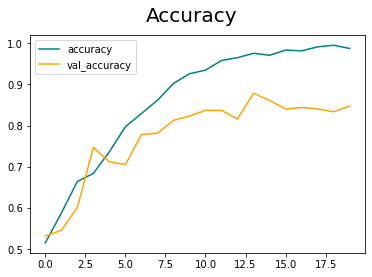

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

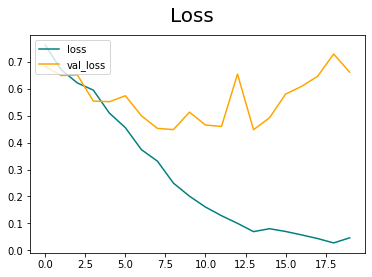

In [22]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Perfomance

Modul yang digunakan:<br>
- BinaryAccuracy : digunakan untuk menghitung seberapa sering prediksi cocok dengan binary label.
- Precision : untuk menghitung ketepatan prediksi sehubungan dengan label.
- Recall : untuk me-recall prediksi.

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [24]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [25]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    test_image = model.predict(X)
    pre.update_state(y, test_image)
    re.update_state(y, test_image)
    acc.update_state(y, test_image)

In [26]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7777777910232544, Recall: 0.7903226017951965, Accuracy: 0.7890625


## Test / Pengujian Suatu Gambar

Gambar yang digunakan yaitu gambar acak, sebisa mungkin merupakan gambar yang belum pernah dikenali sistem kita.

## Test Gambar Anjing

In [ ]:
#jika dijalankan di google colab
# from google.colab import files
# test_image = files.upload()

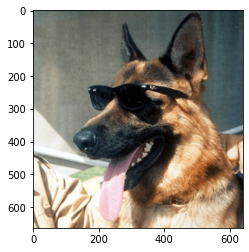

In [55]:
# imread('nama file yang di-upload')
img = cv2.imread('test/kacamata.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

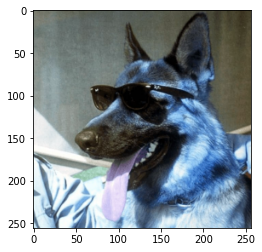

In [56]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [57]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

array([[0.99974775]], dtype=float32)

In [58]:
if yhat > 0.5: 
    print(f'The predicted image belongs to class DOG')
else:
    print(f'The predicted image belongs to class CAT')

The predicted image belongs to class DOG


## Test Gambar Kucing

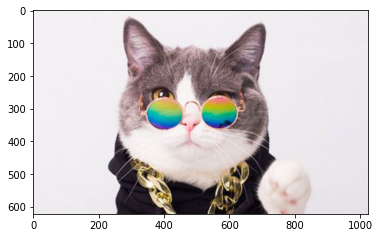

In [63]:
# imread('nama file yang di-upload')
img = cv2.imread('test/kuaci.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

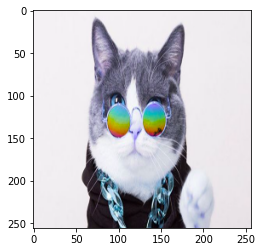

In [64]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [65]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

array([[0.08142149]], dtype=float32)

In [66]:
if yhat > 0.5: 
    print(f'The predicted image belongs to class DOG')
else:
    print(f'The predicted image belongs to class CAT')

The predicted image belongs to class CAT


## Save The Model

Menyimpan model sehingga bisa digunakan kembali

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models', 'CatOrDogModel.h5'))